In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import random
import time
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
class ResBlock(layers.Layer):
    def __init__(self,kernel_sizes = 3, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        
    def build(self, input_shape):
        channels = input_shape[-1]
        self.relU_1 = layers.ReLU()
        self.bn_1 = layers.BatchNormalization()
        self.conv2d_1 = layers.Conv2D(channels, 3, padding = 'same')
        self.relU_2 = layers.ReLU()
        self.bn_2 = layers.BatchNormalization()
        self.conv2d_2 = layers.Conv2D(channels, 3, padding = 'same')
    def call(self, inputs, training = True):
        x = self.relU_1(inputs)
        x = self.bn_1(inputs, training)
        x = self.conv2d_1(x)
        x = self.relU_2(x)
        x = self.bn_2(x)
        x = self.conv2d_2(x)
        out = inputs + x
        return out
        

In [3]:
class OneByOne_Scale(layers.Layer):
    def __init__(self, layer_num, scale_down = True, factor = 2, **kwargs):
        super(OneByOne_Scale, self).__init__(**kwargs)
        self.layer_num = layer_num
        self.scale_down = scale_down
        self.factor = factor
        
    def build(self, input_shape):
        if self.scale_down == True:
            self.scale = layers.MaxPool2D(self.factor)
        else:
            self.scale = layers.UpSampling2D(interpolation = "nearest")
        self.OneByOne = layers.Conv2D(self.layer_num,3, padding = "same")
        self.ReLu = layers.ReLU()
    def output_shape(self, inputs):
        return inputs.shape
    def call(self, inputs):
        x = self.scale(inputs)
        x = self.OneByOne(x)
        x = self.ReLu(x)
        return x
    

In [59]:
class UNET(keras.Model):
    def __init__(self, optimizer):
        super(UNET, self).__init__()
        
        self.optimizer = optimizer 
        
        self.Expand = layers.Conv2D(64,(1,1),activation = "relu")
        self.OneByOne1 = OneByOne_Scale(128)
        self.OneByOne2 = OneByOne_Scale(256)
        self.OneByOne3 = OneByOne_Scale(512)
        self.OneByOne4 = OneByOne_Scale(1024)
        
        self.OneByOne5 = OneByOne_Scale(512, False)
        self.OneByOne6 = OneByOne_Scale(256, False)
        self.OneByOne7 = OneByOne_Scale(128, False)
        self.OneByOne8 = OneByOne_Scale(64, False)
        
        self.ResBlock1 = ResBlock()
        self.ResBlock2 = ResBlock()
        self.ResBlock3 = ResBlock()
        self.ResBlock4 = ResBlock()
        self.ResBlock5 = ResBlock()
        
        self.ResBlock6 = ResBlock()
        self.ResBlock7 = ResBlock()
        self.ResBlock8 = ResBlock()
        self.ResBlock9 = ResBlock()
        
        self.FinalOneByOne = layers.Conv2D(kernel_size = (1,1), filters = 3, activation = 'sigmoid', padding = 'same')

        
    def call(self, inputs):
        
        channel_upsample64 = self.Expand(inputs)
        x1 = self.ResBlock1(channel_upsample64)
        x2 = self.OneByOne1(x1)
        x2 = layers.Dropout(50)(self.ResBlock2(x2))
        x3 = self.OneByOne2(x2)
        x3 = self.ResBlock3(x3)
        #[batch, 128,128,256]
        
        x4 = self.OneByOne3(x3)
        x4 = self.ResBlock4(x4)
        #[batch, 64,64,512]
        

        x5 = self.OneByOne4(x4)
        x5 = self.ResBlock5(x5)
        #[batch,32,32,1024]
        
        
        x4_up = self.OneByOne5(x5)
        x4_concat = tf.concat([x4,x4_up], axis = -1)        
        x4_concat = self.ResBlock6(x4_concat)
        
        
        x3_up = self.OneByOne6(x4_concat)
        x3_concat = tf.concat([x3,x3_up], axis = -1)
        x3_concat = self.ResBlock7(x3_concat)
        
     
        
        x2_up = self.OneByOne7(x3_concat)
        x2_concat = tf.concat([x2,x2_up], axis = -1)
        x2_concat = self.ResBlock8(x2_concat)
        
        
        x1_up = self.OneByOne8(x2_concat)
        x1_concat = tf.concat([x1,x1_up], axis = -1)
        x1_concat = self.ResBlock9(x1_concat)
        
        out = self.FinalOneByOne(x1_concat)
        return out
        
        

In [5]:
class PatchDiscriminator(keras.Model):
    def __init__(self,patch_size):
        super(PatchDiscriminator, self).__init__()
        self.patch_size = patch_size
        
        self.InitialConv2D = layers.Conv2D(kernel_size = (7,7), filters = 64, activation = 'relu', padding = 'same')
        self.FinalConv = layers.Conv2D(kernel_size = 3, filters = 1, activation = 'sigmoid', padding = 'same')
        
        self.ResBlock1 = ResBlock()
        self.ResBlock2 = ResBlock()
        self.ResBlock3 = ResBlock()
        self.ResBlock4 = ResBlock()
        self.ResBlock5 = ResBlock()
        
        
    def call(self, inputs):
        x = self.InitialConv2D(inputs)
        x = self.ResBlock1(x)
        x = self.ResBlock2(x)
        x = self.ResBlock3(x)
        x = self.ResBlock4(x)
        x = self.ResBlock5(x)
        
        x = self.FinalConv(x)
        x = tf.reduce_mean(x,axis=[1,2,3])
        
        return x
    
    
        

In [6]:
# test_layer = layers.ConvLSTM2D(filters = 64, kernel_size = (3,3), return_sequences = True)
# x = tf.random.normal((4,2,16,16,3))
# test_layer(x)
class PatchDiscriminatorLSTM(keras.Model):
    def __init__(self, optimizer, patch_size):
        super(PatchDiscriminatorLSTM, self).__init__()
        
        self.optimizer = optimizer
        self.patch_size = patch_size
        
        self.ConvLSTM1 = layers.ConvLSTM2D(filters = 64, padding = 'valid', strides = 3, kernel_size = 7, return_sequences = True)
        self.ConvLSTM2 = layers.ConvLSTM2D(filters = 128, padding = 'valid', strides = 3, kernel_size = 5, return_sequences = True)
        self.ConvLSTM3 = layers.ConvLSTM2D(filters = 256, padding = 'valid', strides = 3, kernel_size = 3, return_sequences = False)
        self.Conv1 = layers.Conv2D(filters = 64, padding = 'same', strides = 3, kernel_size = 3, activation = 'relu')
        self.Conv2 = layers.Conv2D(filters = 1, padding = 'same', strides = 3, kernel_size = self.patch_size, activation = 'sigmoid')
    
    def call(self, inputs):
        x = self.ConvLSTM1(inputs)
        x = self.ConvLSTM2(x)
        x = self.ConvLSTM3(x)
        x = self.Conv1(x)
        x = self.Conv2(x) 
        out = tf.reduce_mean(x,axis=[1,2,3])
        return out
    
    

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss, real_loss, fake_loss

In [13]:
def generator_loss(disc_decision, fake_output, ground_truth, alpha):
    l1_loss = tf.reduce_mean(tf.abs(fake_output-ground_truth))
    gen_loss = cross_entropy(tf.ones_like(disc_decision), disc_decision)
    total_loss = gen_loss + alpha * l1_loss
    return total_loss, gen_loss, l1_loss

In [1]:
def BatchGenerator(batch_size, im_dir, look_back, height, width):
    photo_dir = glob.glob(im_dir + "/*.jpg")
    while True:
        photo_pairs = np.zeros((batch_size,look_back,height, width, 3)) 
        for i in range(batch_size):
            photo1_id = random.randint(look_back,len(photo_dir)-3)
            
            id1 = f'{photo1_id:03d}'
            id2 = f'{photo1_id+1:03d}'
            
            photo1_path = im_dir + '/0' + id1 + '.jpg'
            photo2_path = im_dir + '/0' + id2 + '.jpg'            
            
            photo1_array = (np.asarray(Image.open(photo1_path).resize((height,width)))-127.5)/127.5
            photo2_array = (np.asarray(Image.open(photo2_path).resize((height,width)))-127.5)/127.5
            
            photo_pairs[i,0] = photo1_array
            photo_pairs[i,1] = photo2_array
        yield tf.cast(photo_pairs, tf.float32)
        

In [10]:
batch = BatchGenerator(6,'./NatureTrim', 2, 512,512).__next__()
a = batch[1,0]
PIL_image = Image.fromarray(np.uint8((127.5*a)+127.5)).convert('RGB')
PIL_image.save("frea.jpg")

In [76]:
@tf.function
def train_step(batch_generator, gen, disc, batch_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        d_train = batch_generator.__next__()
        g_train = batch_generator.__next__()
        
        #calculate Generator Loss
        g_images_for_d = gen(d_train[:batch_size//2,0])
        g_images_for_d = tf.expand_dims(g_images_for_d,1)       
    

        d_train = tf.expand_dims(d_train[:batch_size//2,0], 1)
        print(d_train.shape, g_images_for_d.dtype)
        
        
        g_concat = tf.concat([d_train, g_images_for_d], axis = 1)
        fake_pred = disc(g_concat)
        
        real_pred = disc(d_train)
        
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_loss(real_pred, fake_pred)

        #calculate Discriminator Loss
        
        fake_image = gen(g_train[:,0])
        fake_image = tf.expand_dims(fake_image,1)
        g_train_temp = tf.expand_dims(g_train[:,0], axis = 1)
        fake_pred_for_gen = disc(tf.concat([g_train_temp,fake_image],axis = 1))                      
        gen_loss, gen_disc_loss, l1_loss = generator_loss(fake_pred_for_gen,fake_image, g_train[:1], 1)
        

        
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc.trainable_variables)
        
    gen.optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    disc.optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))
    
    return (disc_real_loss, disc_fake_loss, gen_disc_loss, l1_loss)


In [77]:
BATCH_SIZE = 2
BATCH_GENERATOR = BatchGenerator(BATCH_SIZE,'./NatureTrim', 2, 512,512)
EPOCHS = 6
STEPS_PER_EPOCH = 12
OPTIMIZER = keras.optimizers.Adam(1e-4)
GENERATOR = UNET(OPTIMIZER)
DISCRIMINATOR = PatchDiscriminatorLSTM(OPTIMIZER,70)

In [78]:
def train_loop(Generator, Discriminator, batch_size, epochs, steps_per_epoch, batch_generator):
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=Generator.optimizer,
                                 discriminator_optimizer=Discriminator.optimizer,
                                 generator=Generator,
                                 discriminator=Discriminator)
    seed = batch_generator.__next__()[0:1,0]
    
    disc_real_loss_hist = []
    disc_fake_loss_hist = []
    gen_loss_1_hist = []
    gen_loss_2_hist = []
    
    
    for epoch in range(epochs):
        
        start = time.time()
        
        for step in range(steps_per_epoch):
            losses = train_step(batch_generator,Generator,Discriminator,batch_size)
            print('disc real loss = %.8f disc fake loss %.8f gen loss 1 %.8f gen loss 2 %.8f' %\
                  (losses[0].numpy(), losses[1].numpy(), losses[2].numpy(), losses[3].numpy()))
            
            
            
            disc_real_loss_hist.append([epoch, losses[0].numpy()])
            disc_fake_loss_hist.append([epoch, losses[1].numpy()])
            gen_loss_1_hist.append([epoch, losses[2].numpy()])
            gen_loss_2_hist.append([epoch, losses[3].numpy()])
            
            
        
        print("time for epoch %d is %.2f" % (epoch, time.time()-start))
        
        generate_and_save_images(Generator,
                             epoch + 1,
                             seed)
        
        if (epoch%15 == 1):
            
            plotter(np.asarray(disc_real_loss_hist),np.asarray(disc_fake_loss_hist),
                   np.asarray(gen_loss_1_hist), np.asarray(gen_loss_2_hist), epoch)
            
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        
            

In [79]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False)
    np.save("ims_at" + str(epoch), predictions)


In [80]:
def plotter(a1,a2,a3,a4, epoch):
    plt.plot(a1[:,0],a1[:,1], alpha=0.7, label = 'disc_real_loss')
    plt.plot(a2[:,0],a2[:,1], alpha=0.7, label = 'disc_fake_loss')
    plt.plot(a3[:,0],a3[:,1], alpha=0.7, label = 'gen_loss_1')
    plt.plot(a4[:,0],a4[:,1], alpha=0.7, label = 'gen_loss_2')
    plt.legend()
    plt.savefig("losses_" + str(epoch), bbox_inches='tight', dpi=300)
    

(1, 1, 512, 512, 3) <dtype: 'float32'>
(1, 1, 512, 512, 3) <dtype: 'float32'>
disc real loss = 0.47407639 disc fake loss 0.97407824 gen loss 1 0.47407472 gen loss 2 0.89315826
time for epoch 0 is 74.19
disc real loss = 0.47408423 disc fake loss 0.97405726 gen loss 1 0.47408524 gen loss 2 0.51446813
time for epoch 1 is 48.20
disc real loss = 0.47409499 disc fake loss 0.97403920 gen loss 1 0.47409630 gen loss 2 0.32106903
time for epoch 2 is 54.40


KeyboardInterrupt: 

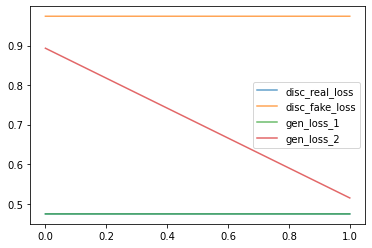

In [81]:
BATCH_SIZE = 2
BATCH_GENERATOR = BatchGenerator(BATCH_SIZE,'./NatureTrim', 2, 512,512)
EPOCHS = 6
STEPS_PER_EPOCH = 1
OPTIMIZER = keras.optimizers.Adam(1e-4)
GENERATOR = UNET(OPTIMIZER)
DISCRIMINATOR = PatchDiscriminatorLSTM(OPTIMIZER,70)

train_loop(GENERATOR, DISCRIMINATOR, BATCH_SIZE, EPOCHS, STEPS_PER_EPOCH, BATCH_GENERATOR)